<a href="https://colab.research.google.com/github/Shankar1920/FMML-22B21A4556/blob/main/FMML_Module_9_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

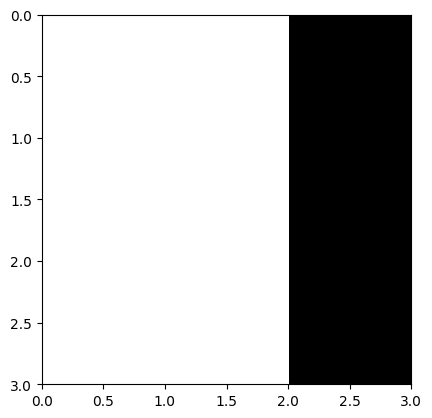

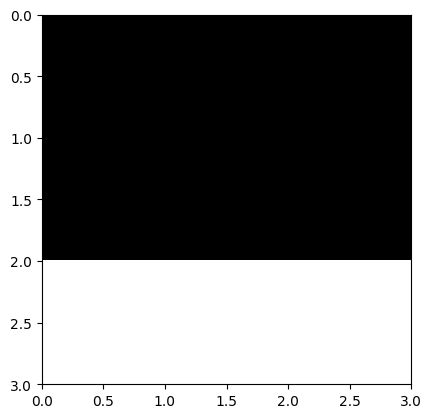

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [20]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [21]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 94043172.49it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [22]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [23]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [24]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [25]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [28]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [30]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0088, Accuracy: 60.2460
Epoch 2/5, Loss: 0.0075, Accuracy: 66.3040
Epoch 3/5, Loss: 0.0065, Accuracy: 70.8300
Epoch 4/5, Loss: 0.0057, Accuracy: 74.4500
Epoch 5/5, Loss: 0.0049, Accuracy: 77.7260


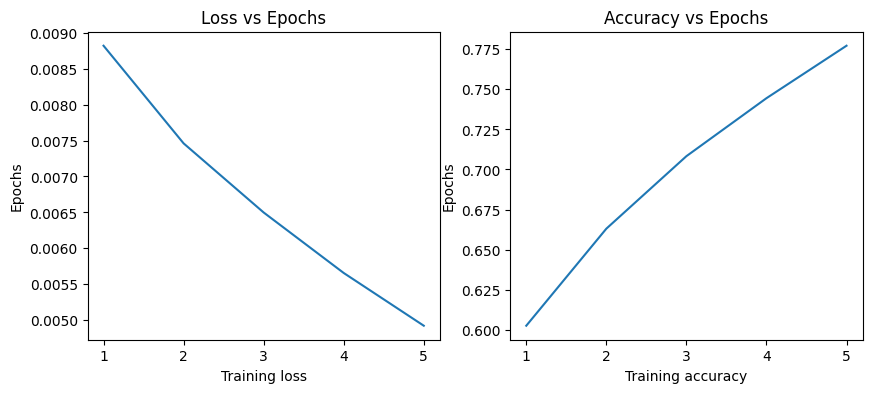

In [31]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [32]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 66 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


**1ST ANSWER**

Convolutional Neural Networks (CNNs) are preferred over traditional Artificial Neural Networks (ANNs) for image classification tasks due to several key advantages that leverage the spatial structure and hierarchical nature of images. Here are some reasons why CNNs are more suitable for image classification:

1. **Hierarchical Feature Learning**:
   CNNs are designed to automatically learn hierarchical representations of features in images. The initial layers detect basic features like edges and textures, while deeper layers learn complex features like shapes and objects. This hierarchical learning is crucial for understanding the spatial structure of images.

2. **Spatial Invariance**:
   CNNs exploit the spatial locality of data by using shared weights (filters) across the input. This allows them to be invariant to translation, meaning they can recognize patterns regardless of their location in the image. This property is beneficial for tasks like object recognition where the position of objects may vary.

3. **Parameter Sharing**:
   CNNs use parameter sharing through convolutional filters, which significantly reduces the number of parameters compared to fully connected networks (ANNs). This reduces the risk of overfitting and allows CNNs to generalize better to unseen data.

4. **Local Connectivity**:
   CNNs capture local spatial dependencies through convolutional operations. Each neuron is connected to only a local region of the input volume, enabling them to learn spatial hierarchies efficiently.

5. **Efficient Feature Extraction**:
   CNNs excel at automatically extracting relevant features from images. The convolutional layers act as feature extractors that learn to identify important patterns, textures, and shapes directly from raw pixel data.

6. **Ability to Learn Spatial Hierarchies**:
   By using multiple convolutional layers followed by pooling layers, CNNs can learn increasingly abstract and complex features, mimicking the hierarchical organization of visual information in the human visual system.

7. **Effective Parameter Optimization**:
   CNNs leverage techniques like backpropagation and gradient descent for parameter optimization, making them efficient in learning the optimal set of weights to minimize the loss function.

8. **State-of-the-Art Performance in Image Tasks**:
   CNNs have demonstrated state-of-the-art performance in various image-related tasks such as image classification, object detection, and segmentation. They have been instrumental in advancing the field of computer vision.

Overall, CNNs are tailored specifically for processing grid-like data such as images, exploiting spatial relationships and hierarchical structures inherent in visual data. Their architecture and properties make them highly effective and efficient for tasks involving image classification and analysis.

**2ND ANSWER**

Improving the performance of a Convolutional Neural Network (CNN) involves tuning various hyperparameters such as the number of epochs, choice of optimizer, learning rate, batch size, and possibly the architecture of the network itself. Here's a step-by-step guide on how you can proceed to improve CNN performance and report the test accuracy:

### 1. Dataset Preparation
   - **Load and preprocess the dataset**: Use a suitable dataset for image classification (e.g., CIFAR-10, MNIST). Preprocess the images (e.g., normalization, resizing) and split them into training, validation, and test sets.

### 2. Model Definition
   - **Design the CNN architecture**: Choose an appropriate architecture for your CNN, including convolutional layers, pooling layers, dropout (for regularization), and fully connected layers.
   - Example CNN architecture using Keras:
     ```python
     from tensorflow.keras.models import Sequential
     from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

     model = Sequential([
         Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
         MaxPooling2D((2, 2)),
         Conv2D(64, (3, 3), activation='relu'),
         MaxPooling2D((2, 2)),
         Flatten(),
         Dense(128, activation='relu'),
         Dropout(0.5),
         Dense(10, activation='softmax')
     ])
     ```

### 3. Model Compilation
   - **Compile the model**: Specify the loss function, optimizer, and metrics for training.
   - Example compilation using Keras:
     ```python
     model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
     ```

### 4. Hyperparameter Tuning
   - **Define hyperparameters**: Choose hyperparameters to tune, such as epochs, learning rate, batch size, and optimizer.
   - **Use techniques like grid search or random search**: Experiment with different combinations of hyperparameters to find the optimal configuration.
   - Example hyperparameter tuning using Keras and TensorFlow:
     ```python
     from tensorflow.keras.callbacks import EarlyStopping

     # Define hyperparameters
     epochs = 20
     batch_size = 64
     learning_rate = 0.001

     # Compile and train the model
     history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size,
                         validation_data=(val_images, val_labels),
                         callbacks=[EarlyStopping(patience=3)],
                         verbose=1)
     ```

### 5. Evaluate the Model
   - **Evaluate the model on the test set**: After training, evaluate the model's performance on the test set to report the test accuracy.
   - Example evaluation using Keras:
     ```python
     test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
     print(f"Test Accuracy: {test_accuracy}")
     ```

### 6. Iterative Improvement
   - **Iteratively tune hyperparameters**: Based on the initial results, refine your choices of hyperparameters and model architecture to further optimize performance.

### Example Workflow
Here's an illustrative workflow incorporating the above steps:

```python
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with hyperparameter tuning
history = model.fit(train_images, train_labels, epochs=20, batch_size=64,
                    validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy}")
```

In this example:
- We use the CIFAR-10 dataset for image classification.
- The CNN architecture includes convolutional layers, max pooling, dropout for regularization, and dense layers.
- We use the Adam optimizer with a specified learning rate (`learning_rate=0.001`).
- The model is trained for 20 epochs with a batch size of 64.
- After training, we evaluate the model's performance on the test set to report the test accuracy.

You can further refine this workflow by experimenting with different hyperparameters (e.g., learning rate, batch size, number of epochs) and exploring advanced techniques like learning rate scheduling, early stopping, and more complex architectures to achieve improved performance in your CNN-based image classification task. Iteratively tuning these parameters and experimenting with different configurations will help optimize the model's accuracy.

**3RD ANSWER**

Reducing the number of convolutional layers to only one in a Convolutional Neural Network (CNN) can have several implications on the network's ability to learn and extract meaningful features from input data, particularly for complex tasks like image classification. Here are some key points to consider when reducing the number of convolutional layers:

1. **Feature Extraction Capability**:
   Convolutional layers are responsible for extracting hierarchical features from the input data. Multiple convolutional layers allow the network to learn increasingly abstract and complex features. With only one convolutional layer, the network's capability to extract diverse and high-level features may be limited.

2. **Model Complexity and Capacity**:
   CNNs with multiple convolutional layers have higher model complexity and capacity, enabling them to learn more intricate patterns in the data. A single convolutional layer may not capture enough variations in the input data, potentially leading to underfitting.

3. **Hierarchical Representation**:
   Deep CNN architectures leverage the concept of hierarchical representation learning, where lower layers detect basic features (e.g., edges, textures) and higher layers combine these features to recognize more complex patterns (e.g., shapes, objects). With fewer convolutional layers, the network may struggle to learn such hierarchical representations effectively.

4. **Generalization and Performance**:
   Deeper CNNs often generalize better to unseen data by learning robust and discriminative features. A single convolutional layer might not generalize well and could result in lower performance on validation and test datasets.

5. **Effective Receptive Field**:
   CNNs with multiple layers have larger effective receptive fields, allowing them to capture more contextual information and spatial dependencies within the input data. A single convolutional layer has a limited receptive field, which may not adequately capture the spatial relationships in complex images.

6. **Loss of Depth Benefits**:
   Depth in CNNs (achieved through multiple layers) has been shown to be beneficial for learning complex mappings and achieving state-of-the-art performance in computer vision tasks. Reducing the number of layers reduces the depth of the network, potentially compromising its ability to learn intricate patterns.

In summary, while reducing the number of convolutional layers to one may simplify the network architecture and reduce computational costs, it often comes at the expense of feature learning capability, model capacity, and overall performance. For tasks like image classification where capturing diverse and hierarchical features is critical, it's generally recommended to use deeper CNN architectures with multiple convolutional layers for optimal results. However, the specific choice of network architecture should always be guided by the nature of the task, the complexity of the data, and available computational resources.

**4TH ANSWER**

The decision to use or not use the Softmax activation function in the last layer of a Convolutional Neural Network (CNN) depends on the specific task being addressed by the network. Here are some considerations:

1. **Nature of the Task**:
   - **Multiclass Classification**: If the task involves multiclass classification (i.e., predicting one of multiple mutually exclusive classes), it's typical to use Softmax activation in the last layer. Softmax converts raw logits into probabilities, ensuring that the output values represent the likelihood or confidence scores for each class.
   - **Other Tasks**: For tasks like binary classification (where there are only two classes) or regression tasks (predicting continuous values), different activation functions (e.g., Sigmoid for binary classification, Linear for regression) may be more appropriate in the output layer.

2. **Loss Function Compatibility**:
   - Softmax activation is often paired with the categorical cross-entropy loss function for multiclass classification tasks. This combination helps in optimizing the network's weights to minimize the cross-entropy loss, thereby improving the model's ability to correctly classify input samples into their respective classes.

3. **Model Output Interpretation**:
   - Softmax activation normalizes the output layer into a probability distribution across multiple classes. Each output neuron represents the probability of the corresponding class, and the sum of probabilities for all classes equals one. This makes the model's predictions interpretable and suitable for decision-making based on class probabilities.

4. **Decision Boundary and Class Separation**:
   - Softmax activation helps in establishing clear decision boundaries between classes by assigning higher probabilities to the correct class and lower probabilities to other classes. This facilitates effective class separation and reduces ambiguity in predictions.

In some cases, Softmax activation may not be used in the last layer of a CNN if:
   - The task is not multiclass classification (e.g., binary classification or regression).
   - The network is part of a larger architecture (e.g., used as a feature extractor in a more complex system) where the final decision-making is handled by another component downstream.

Therefore, when designing a CNN, the choice of activation function in the last layer should align with the specific requirements and objectives of the task, ensuring that the network's output is compatible with the desired model behavior and performance metrics.